In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
    !pip install -q -U tf-agents-nightly pyvirtualdisplay gym[atari]
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. CNNs can be very slow without a GPU.


In [2]:
import gym

In [3]:
tf.random.set_seed(42)
np.random.seed(42)

In [4]:
from tf_agents.environments import suite_gym

env = suite_gym.load("Breakout-v4")
env

In [5]:
env.seed(42)
env.reset()

TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))

Saving figure breakout_plot


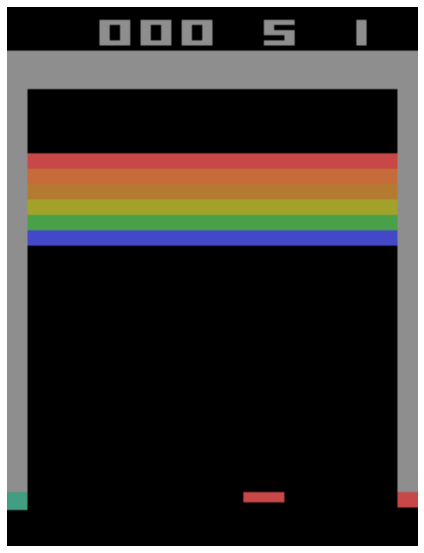

In [6]:
action = np.array(3, dtype=np.int32)
env.step(action) # Fire
img = env.render(mode="rgb_array")

plt.figure(figsize=(6, 8))
plt.imshow(img)
plt.axis("off")
save_fig("breakout_plot")
plt.show()

In [7]:
env.current_time_step()

TimeStep(step_type=array(1, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))

In [8]:
env.observation_spec()

BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255)

In [9]:
env.action_spec()

BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=3)

In [10]:
env.time_step_spec()

TimeStep(step_type=ArraySpec(shape=(), dtype=dtype('int32'), name='step_type'), reward=ArraySpec(shape=(), dtype=dtype('float32'), name='reward'), discount=BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0), observation=BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255))

In [11]:
from tf_agents.environments.wrappers import ActionRepeat

repeating_env = ActionRepeat(env, times=4)
repeating_env



In [12]:
repeating_env.unwrapped

In [13]:
import tf_agents.environments.wrappers

for name in dir(tf_agents.environments.wrappers):
    obj = getattr(tf_agents.environments.wrappers, name)
    if hasattr(obj, "__base__") and issubclass(obj, tf_agents.environments.wrappers.PyEnvironmentBaseWrapper):
        print("{:27s} {}".format(name, obj.__doc__.split("\n")[0]))

ActionClipWrapper           Wraps an environment and clips actions to spec before applying.
ActionDiscretizeWrapper     Wraps an environment with continuous actions and discretizes them.
ActionOffsetWrapper         Offsets actions to be zero-based.
ActionRepeat                Repeates actions over n-steps while acummulating the received reward.
FlattenObservationsWrapper  Wraps an environment and flattens nested multi-dimensional observations.
GoalReplayEnvWrapper        Adds a goal to the observation, used for HER (Hindsight Experience Replay).
HistoryWrapper              Adds observation and action history to the environment's observations.
ObservationFilterWrapper    Filters observations based on an array of indexes.
OneHotActionWrapper         Converts discrete action to one_hot format.
PerformanceProfiler         End episodes after specified number of steps.
PyEnvironmentBaseWrapper    PyEnvironment wrapper forwards calls to the given environment.
RunStats                    Wrapp

In [14]:
from functools import partial
from gym.wrappers import TimeLimit

limited_repeating_env = suite_gym.load(
    "Breakout-v4",
    gym_env_wrappers=[partial(TimeLimit, max_episode_steps=10000)],
    env_wrappers=[partial(ActionRepeat, times=4)],
)

In [15]:
limited_repeating_env

In [16]:
limited_repeating_env.unwrapped

In [17]:
from tf_agents.environments import suite_atari
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4

max_episode_steps = 27000 # <=> 108k ALE frames since 1 step = 4 frames
environment_name = "BreakoutNoFrameskip-v4"

env = suite_atari.load(
    environment_name,
    max_episode_steps=max_episode_steps,
    gym_env_wrappers=[AtariPreprocessing, FrameStack4])

In [18]:
env

In [19]:
env.seed(42)
env.reset()
action = np.array(1, dtype=np.int32)
env.step(action) # Fire
 
for _ in range(4):
    action = np.array(3, dtype=np.int32)
    time_step = env.step(action) # LEFT
    
 

In [20]:
def plot_observation(obs):
    # Since there are only 3 color channels, you cannot display 4 frames
    # with one primary color per frame. So this code computes the delta between
    # the current frame and the mean of the other frames, and it adds this delta
    # to the red and blue channels to get a pink color for the current frame.
    obs = obs.astype(np.float32)
    img = obs[..., :3]
    current_frame_delta = np.maximum(obs[..., 3] - obs[..., :3].mean(axis=-1), 0.)
    img[..., 0] += current_frame_delta
    img[..., 2] += current_frame_delta
    img = np.clip(img / 150, 0, 1)
    plt.imshow(img)
    plt.axis("off")
 

Saving figure preprocessed_breakout_plot


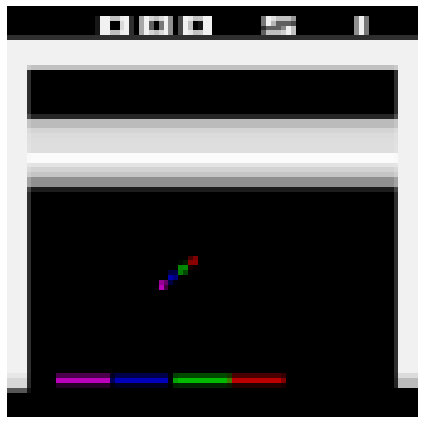

In [21]:
plt.figure(figsize=(6, 6))
plot_observation(time_step.observation)
save_fig("preprocessed_breakout_plot")
plt.show()

In [22]:
from tf_agents.environments.tf_py_environment import TFPyEnvironment

tf_env = TFPyEnvironment(env)

In [23]:
from tf_agents.networks.q_network import QNetwork

preprocessing_layer = keras.layers.Lambda(
                          lambda obs: tf.cast(obs, np.float32) / 255.)
conv_layer_params=[(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
fc_layer_params=[512]

q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params)

In [24]:
from tf_agents.agents.dqn.dqn_agent import DqnAgent

# see TF-agents issue #113
#optimizer = keras.optimizers.RMSprop(lr=2.5e-4, rho=0.95, momentum=0.0,
#                                     epsilon=0.00001, centered=True)

train_step = tf.Variable(0)
update_period = 4 # run a training step every 4 collect steps
optimizer = tf.compat.v1.train.RMSPropOptimizer(learning_rate=2.5e-4, decay=0.95, momentum=0.0,
                                     epsilon=0.00001, centered=True)
epsilon_fn = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0, # initial ε
    decay_steps=250000 // update_period, # <=> 1,000,000 ALE frames
    end_learning_rate=0.01) # final ε
agent = DqnAgent(tf_env.time_step_spec(),
                 tf_env.action_spec(),
                 q_network=q_net,
                 optimizer=optimizer,
                 target_update_period=2000, # <=> 32,000 ALE frames
                 td_errors_loss_fn=keras.losses.Huber(reduction="none"),
                 gamma=0.99, # discount factor
                 train_step_counter=train_step,
                 epsilon_greedy=lambda: epsilon_fn(train_step))
agent.initialize()

In [25]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=100000)

replay_buffer_observer = replay_buffer.add_batch

In [26]:
class ShowProgress:
    def __init__(self, total):
        self.counter = 0
        self.total = total
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")

In [27]:
from tf_agents.metrics import tf_metrics

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric(),
]

In [28]:
train_metrics[0].result()

<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [29]:
from tf_agents.eval.metric_utils import log_metrics
import logging
logging.getLogger().setLevel(logging.INFO)
log_metrics(train_metrics)

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 0
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


In [30]:
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

collect_driver = DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers=[replay_buffer_observer] + train_metrics,
    num_steps=update_period) # collect 4 steps for each training iteration

In [31]:
from tf_agents.policies.random_tf_policy import RandomTFPolicy

initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(),
                                        tf_env.action_spec())
init_driver = DynamicStepDriver(
    tf_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch, ShowProgress(20000)],
    num_steps=20000) # <=> 80,000 ALE frames
final_time_step, final_policy_state = init_driver.run()

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


20000/20000

In [32]:
tf.random.set_seed(888) # chosen to show an example of trajectory at the end of an episode

trajectories, buffer_info = replay_buffer.get_next(
    sample_batch_size=2, num_steps=3)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [33]:
trajectories._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [34]:
trajectories.observation.shape

TensorShape([2, 3, 84, 84, 4])

In [35]:
from tf_agents.trajectories.trajectory import to_transition

time_steps, action_steps, next_time_steps = to_transition(trajectories)
time_steps.observation.shape

TensorShape([2, 2, 84, 84, 4])

In [36]:
trajectories.step_type.numpy()

array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)

Saving figure sub_episodes_plot


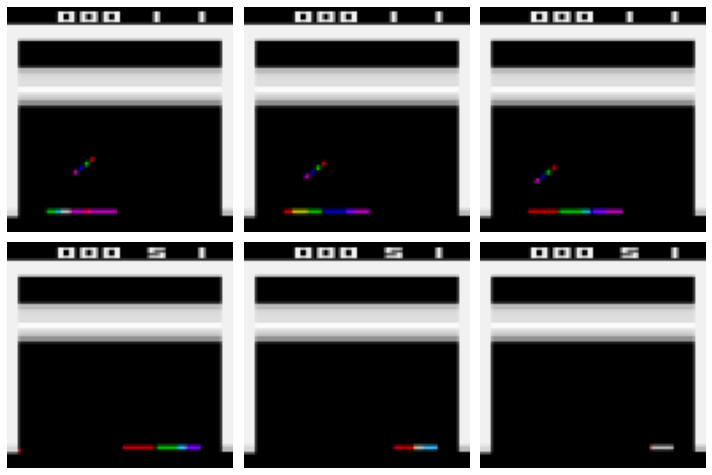

In [37]:
plt.figure(figsize=(10, 6.8))
for row in range(2):
    for col in range(3):
        plt.subplot(2, 3, row * 3 + col + 1)
        plot_observation(trajectories.observation[row, col].numpy())
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0.02)
save_fig("sub_episodes_plot")
plt.show()

In [38]:
dataset = replay_buffer.as_dataset(
    sample_batch_size=64,
    num_steps=2,
    num_parallel_calls=3).prefetch(3)

In [39]:
from tf_agents.utils.common import function

collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)

In [40]:
def train_agent(n_iterations):
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size)
    iterator = iter(dataset)
    for iteration in range(n_iterations):
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        train_loss = agent.train(trajectories)
        print("\r{} loss:{:.5f}".format(
            iteration, train_loss.loss.numpy()), end="")
        if iteration % 100 == 0:
            log_metrics(train_metrics)

In [41]:
train_agent(n_iterations=20000)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 4
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


94 loss:0.00368

INFO:absl: 
		 NumberOfEpisodes = 3
		 EnvironmentSteps = 404
		 AverageReturn = 0.3333333432674408
		 AverageEpisodeLength = 125.33333587646484


194 loss:0.00799

INFO:absl: 
		 NumberOfEpisodes = 5
		 EnvironmentSteps = 804
		 AverageReturn = 0.800000011920929
		 AverageEpisodeLength = 151.39999389648438


299 loss:0.00006

INFO:absl: 
		 NumberOfEpisodes = 7
		 EnvironmentSteps = 1204
		 AverageReturn = 0.8571428656578064
		 AverageEpisodeLength = 159.0


396 loss:0.00003

INFO:absl: 
		 NumberOfEpisodes = 10
		 EnvironmentSteps = 1604
		 AverageReturn = 0.699999988079071
		 AverageEpisodeLength = 153.39999389648438


495 loss:0.00001

INFO:absl: 
		 NumberOfEpisodes = 12
		 EnvironmentSteps = 2004
		 AverageReturn = 0.800000011920929
		 AverageEpisodeLength = 164.3000030517578


594 loss:0.00001

INFO:absl: 
		 NumberOfEpisodes = 15
		 EnvironmentSteps = 2404
		 AverageReturn = 0.699999988079071
		 AverageEpisodeLength = 159.8000030517578


694 loss:0.00010

INFO:absl: 
		 NumberOfEpisodes = 17
		 EnvironmentSteps = 2804
		 AverageReturn = 0.800000011920929
		 AverageEpisodeLength = 161.89999389648438


795 loss:0.00043

INFO:absl: 
		 NumberOfEpisodes = 20
		 EnvironmentSteps = 3204
		 AverageReturn = 0.699999988079071
		 AverageEpisodeLength = 161.0


897 loss:0.00011

INFO:absl: 
		 NumberOfEpisodes = 21
		 EnvironmentSteps = 3604
		 AverageReturn = 0.800000011920929
		 AverageEpisodeLength = 164.5


998 loss:0.00043

INFO:absl: 
		 NumberOfEpisodes = 23
		 EnvironmentSteps = 4004
		 AverageReturn = 1.0
		 AverageEpisodeLength = 174.89999389648438


1099 loss:0.00020

INFO:absl: 
		 NumberOfEpisodes = 26
		 EnvironmentSteps = 4404
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 172.6999969482422


1198 loss:0.00006

INFO:absl: 
		 NumberOfEpisodes = 28
		 EnvironmentSteps = 4804
		 AverageReturn = 0.800000011920929
		 AverageEpisodeLength = 170.39999389648438


1298 loss:0.00780

INFO:absl: 
		 NumberOfEpisodes = 31
		 EnvironmentSteps = 5204
		 AverageReturn = 1.0
		 AverageEpisodeLength = 180.1999969482422


1399 loss:0.00005

INFO:absl: 
		 NumberOfEpisodes = 33
		 EnvironmentSteps = 5604
		 AverageReturn = 0.699999988079071
		 AverageEpisodeLength = 167.3000030517578


1495 loss:0.00768

INFO:absl: 
		 NumberOfEpisodes = 35
		 EnvironmentSteps = 6004
		 AverageReturn = 0.6000000238418579
		 AverageEpisodeLength = 164.1999969482422


1597 loss:0.00014

INFO:absl: 
		 NumberOfEpisodes = 38
		 EnvironmentSteps = 6404
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 172.8000030517578


1698 loss:0.00003

INFO:absl: 
		 NumberOfEpisodes = 41
		 EnvironmentSteps = 6804
		 AverageReturn = 0.6000000238418579
		 AverageEpisodeLength = 157.6999969482422


1794 loss:0.01571

INFO:absl: 
		 NumberOfEpisodes = 44
		 EnvironmentSteps = 7204
		 AverageReturn = 0.5
		 AverageEpisodeLength = 152.8000030517578


1896 loss:0.00764

INFO:absl: 
		 NumberOfEpisodes = 46
		 EnvironmentSteps = 7604
		 AverageReturn = 0.4000000059604645
		 AverageEpisodeLength = 147.39999389648438


1997 loss:0.00002

INFO:absl: 
		 NumberOfEpisodes = 48
		 EnvironmentSteps = 8004
		 AverageReturn = 0.5
		 AverageEpisodeLength = 152.39999389648438


2099 loss:0.00002

INFO:absl: 
		 NumberOfEpisodes = 51
		 EnvironmentSteps = 8404
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 165.5


2198 loss:0.01576

INFO:absl: 
		 NumberOfEpisodes = 53
		 EnvironmentSteps = 8804
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 164.39999389648438


2299 loss:0.00792

INFO:absl: 
		 NumberOfEpisodes = 56
		 EnvironmentSteps = 9204
		 AverageReturn = 1.0
		 AverageEpisodeLength = 167.39999389648438


2397 loss:0.00006

INFO:absl: 
		 NumberOfEpisodes = 58
		 EnvironmentSteps = 9604
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 163.39999389648438


2498 loss:0.00002

INFO:absl: 
		 NumberOfEpisodes = 61
		 EnvironmentSteps = 10004
		 AverageReturn = 0.6000000238418579
		 AverageEpisodeLength = 157.1999969482422


2599 loss:0.00781

INFO:absl: 
		 NumberOfEpisodes = 63
		 EnvironmentSteps = 10404
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 168.5


2697 loss:0.00003

INFO:absl: 
		 NumberOfEpisodes = 66
		 EnvironmentSteps = 10804
		 AverageReturn = 0.699999988079071
		 AverageEpisodeLength = 162.89999389648438


2797 loss:0.00002

INFO:absl: 
		 NumberOfEpisodes = 68
		 EnvironmentSteps = 11204
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 170.60000610351562


2898 loss:0.00001

INFO:absl: 
		 NumberOfEpisodes = 71
		 EnvironmentSteps = 11604
		 AverageReturn = 0.699999988079071
		 AverageEpisodeLength = 160.89999389648438


2994 loss:0.00017

INFO:absl: 
		 NumberOfEpisodes = 73
		 EnvironmentSteps = 12004
		 AverageReturn = 0.5
		 AverageEpisodeLength = 153.8000030517578


3096 loss:0.00007

INFO:absl: 
		 NumberOfEpisodes = 75
		 EnvironmentSteps = 12404
		 AverageReturn = 0.800000011920929
		 AverageEpisodeLength = 164.60000610351562


3198 loss:0.00007

INFO:absl: 
		 NumberOfEpisodes = 78
		 EnvironmentSteps = 12804
		 AverageReturn = 0.6000000238418579
		 AverageEpisodeLength = 158.3000030517578


3294 loss:0.00002

INFO:absl: 
		 NumberOfEpisodes = 81
		 EnvironmentSteps = 13204
		 AverageReturn = 0.699999988079071
		 AverageEpisodeLength = 161.5


3396 loss:0.00009

INFO:absl: 
		 NumberOfEpisodes = 83
		 EnvironmentSteps = 13604
		 AverageReturn = 0.6000000238418579
		 AverageEpisodeLength = 160.8000030517578


3495 loss:0.00001

INFO:absl: 
		 NumberOfEpisodes = 85
		 EnvironmentSteps = 14004
		 AverageReturn = 0.800000011920929
		 AverageEpisodeLength = 167.10000610351562


3595 loss:0.00001

INFO:absl: 
		 NumberOfEpisodes = 87
		 EnvironmentSteps = 14404
		 AverageReturn = 1.100000023841858
		 AverageEpisodeLength = 174.0


3699 loss:0.00002

INFO:absl: 
		 NumberOfEpisodes = 90
		 EnvironmentSteps = 14804
		 AverageReturn = 1.100000023841858
		 AverageEpisodeLength = 172.5


3795 loss:0.00016

INFO:absl: 
		 NumberOfEpisodes = 93
		 EnvironmentSteps = 15204
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 162.3000030517578


3897 loss:0.00010

INFO:absl: 
		 NumberOfEpisodes = 94
		 EnvironmentSteps = 15604
		 AverageReturn = 0.800000011920929
		 AverageEpisodeLength = 158.60000610351562


3997 loss:0.00002

INFO:absl: 
		 NumberOfEpisodes = 96
		 EnvironmentSteps = 16004
		 AverageReturn = 0.800000011920929
		 AverageEpisodeLength = 166.60000610351562


4098 loss:0.00002

INFO:absl: 
		 NumberOfEpisodes = 98
		 EnvironmentSteps = 16404
		 AverageReturn = 1.2000000476837158
		 AverageEpisodeLength = 185.89999389648438


4194 loss:0.00011

INFO:absl: 
		 NumberOfEpisodes = 101
		 EnvironmentSteps = 16804
		 AverageReturn = 1.2999999523162842
		 AverageEpisodeLength = 189.10000610351562


4296 loss:0.00012

INFO:absl: 
		 NumberOfEpisodes = 103
		 EnvironmentSteps = 17204
		 AverageReturn = 1.7000000476837158
		 AverageEpisodeLength = 201.89999389648438


4398 loss:0.00804

INFO:absl: 
		 NumberOfEpisodes = 105
		 EnvironmentSteps = 17604
		 AverageReturn = 1.399999976158142
		 AverageEpisodeLength = 186.39999389648438


4495 loss:0.00002

INFO:absl: 
		 NumberOfEpisodes = 107
		 EnvironmentSteps = 18004
		 AverageReturn = 1.2999999523162842
		 AverageEpisodeLength = 180.5


4596 loss:0.00001

INFO:absl: 
		 NumberOfEpisodes = 110
		 EnvironmentSteps = 18404
		 AverageReturn = 1.100000023841858
		 AverageEpisodeLength = 174.39999389648438


4698 loss:0.00003

INFO:absl: 
		 NumberOfEpisodes = 112
		 EnvironmentSteps = 18804
		 AverageReturn = 1.100000023841858
		 AverageEpisodeLength = 174.6999969482422


4794 loss:0.00006

INFO:absl: 
		 NumberOfEpisodes = 115
		 EnvironmentSteps = 19204
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 166.6999969482422


4895 loss:0.00046

INFO:absl: 
		 NumberOfEpisodes = 118
		 EnvironmentSteps = 19604
		 AverageReturn = 0.5
		 AverageEpisodeLength = 150.8000030517578


4996 loss:0.00010

INFO:absl: 
		 NumberOfEpisodes = 120
		 EnvironmentSteps = 20004
		 AverageReturn = 0.4000000059604645
		 AverageEpisodeLength = 148.89999389648438


5097 loss:0.00746

INFO:absl: 
		 NumberOfEpisodes = 123
		 EnvironmentSteps = 20404
		 AverageReturn = 0.4000000059604645
		 AverageEpisodeLength = 153.8000030517578


5197 loss:0.00767

INFO:absl: 
		 NumberOfEpisodes = 125
		 EnvironmentSteps = 20804
		 AverageReturn = 0.5
		 AverageEpisodeLength = 161.5


5298 loss:0.00015

INFO:absl: 
		 NumberOfEpisodes = 127
		 EnvironmentSteps = 21204
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 178.89999389648438


5394 loss:0.00001

INFO:absl: 
		 NumberOfEpisodes = 129
		 EnvironmentSteps = 21604
		 AverageReturn = 1.100000023841858
		 AverageEpisodeLength = 182.60000610351562


5498 loss:0.00003

INFO:absl: 
		 NumberOfEpisodes = 131
		 EnvironmentSteps = 22004
		 AverageReturn = 1.2000000476837158
		 AverageEpisodeLength = 183.10000610351562


5599 loss:0.00022

INFO:absl: 
		 NumberOfEpisodes = 133
		 EnvironmentSteps = 22404
		 AverageReturn = 1.5
		 AverageEpisodeLength = 194.60000610351562


5697 loss:0.00740

INFO:absl: 
		 NumberOfEpisodes = 135
		 EnvironmentSteps = 22804
		 AverageReturn = 1.399999976158142
		 AverageEpisodeLength = 189.1999969482422


5796 loss:0.00005

INFO:absl: 
		 NumberOfEpisodes = 138
		 EnvironmentSteps = 23204
		 AverageReturn = 1.100000023841858
		 AverageEpisodeLength = 177.0


5898 loss:0.00002

INFO:absl: 
		 NumberOfEpisodes = 141
		 EnvironmentSteps = 23604
		 AverageReturn = 0.5
		 AverageEpisodeLength = 153.5


5994 loss:0.00787

INFO:absl: 
		 NumberOfEpisodes = 144
		 EnvironmentSteps = 24004
		 AverageReturn = 0.20000000298023224
		 AverageEpisodeLength = 138.39999389648438


6097 loss:0.00011

INFO:absl: 
		 NumberOfEpisodes = 146
		 EnvironmentSteps = 24404
		 AverageReturn = 0.4000000059604645
		 AverageEpisodeLength = 150.0


6196 loss:0.00001

INFO:absl: 
		 NumberOfEpisodes = 149
		 EnvironmentSteps = 24804
		 AverageReturn = 0.5
		 AverageEpisodeLength = 155.3000030517578


6297 loss:0.00001

INFO:absl: 
		 NumberOfEpisodes = 152
		 EnvironmentSteps = 25204
		 AverageReturn = 0.5
		 AverageEpisodeLength = 156.0


6399 loss:0.00019

INFO:absl: 
		 NumberOfEpisodes = 154
		 EnvironmentSteps = 25604
		 AverageReturn = 0.699999988079071
		 AverageEpisodeLength = 166.0


6498 loss:0.00004

INFO:absl: 
		 NumberOfEpisodes = 156
		 EnvironmentSteps = 26004
		 AverageReturn = 0.6000000238418579
		 AverageEpisodeLength = 159.39999389648438


6598 loss:0.00002

INFO:absl: 
		 NumberOfEpisodes = 158
		 EnvironmentSteps = 26404
		 AverageReturn = 1.0
		 AverageEpisodeLength = 171.5


6699 loss:0.00763

INFO:absl: 
		 NumberOfEpisodes = 160
		 EnvironmentSteps = 26804
		 AverageReturn = 1.0
		 AverageEpisodeLength = 171.1999969482422


6798 loss:0.00007

INFO:absl: 
		 NumberOfEpisodes = 162
		 EnvironmentSteps = 27204
		 AverageReturn = 1.600000023841858
		 AverageEpisodeLength = 195.1999969482422


6899 loss:0.00006

INFO:absl: 
		 NumberOfEpisodes = 164
		 EnvironmentSteps = 27604
		 AverageReturn = 1.5
		 AverageEpisodeLength = 190.10000610351562


6994 loss:0.00002

INFO:absl: 
		 NumberOfEpisodes = 166
		 EnvironmentSteps = 28004
		 AverageReturn = 1.600000023841858
		 AverageEpisodeLength = 198.60000610351562


7096 loss:0.00001

INFO:absl: 
		 NumberOfEpisodes = 169
		 EnvironmentSteps = 28404
		 AverageReturn = 1.2999999523162842
		 AverageEpisodeLength = 191.6999969482422


7195 loss:0.00752

INFO:absl: 
		 NumberOfEpisodes = 172
		 EnvironmentSteps = 28804
		 AverageReturn = 0.699999988079071
		 AverageEpisodeLength = 167.8000030517578


7295 loss:0.00003

INFO:absl: 
		 NumberOfEpisodes = 174
		 EnvironmentSteps = 29204
		 AverageReturn = 0.800000011920929
		 AverageEpisodeLength = 174.1999969482422


7396 loss:0.00010

INFO:absl: 
		 NumberOfEpisodes = 175
		 EnvironmentSteps = 29604
		 AverageReturn = 0.5
		 AverageEpisodeLength = 161.8000030517578


7497 loss:0.00001

INFO:absl: 
		 NumberOfEpisodes = 178
		 EnvironmentSteps = 30004
		 AverageReturn = 0.699999988079071
		 AverageEpisodeLength = 164.3000030517578


7598 loss:0.00759

INFO:absl: 
		 NumberOfEpisodes = 180
		 EnvironmentSteps = 30404
		 AverageReturn = 0.699999988079071
		 AverageEpisodeLength = 167.1999969482422


7697 loss:0.00769

INFO:absl: 
		 NumberOfEpisodes = 182
		 EnvironmentSteps = 30804
		 AverageReturn = 1.2000000476837158
		 AverageEpisodeLength = 184.89999389648438


7797 loss:0.00002

INFO:absl: 
		 NumberOfEpisodes = 184
		 EnvironmentSteps = 31204
		 AverageReturn = 1.399999976158142
		 AverageEpisodeLength = 191.10000610351562


7895 loss:0.00761

INFO:absl: 
		 NumberOfEpisodes = 187
		 EnvironmentSteps = 31604
		 AverageReturn = 1.100000023841858
		 AverageEpisodeLength = 175.8000030517578


7995 loss:0.00001

INFO:absl: 
		 NumberOfEpisodes = 190
		 EnvironmentSteps = 32004
		 AverageReturn = 1.100000023841858
		 AverageEpisodeLength = 176.1999969482422


8095 loss:0.00009

INFO:absl: 
		 NumberOfEpisodes = 191
		 EnvironmentSteps = 32404
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 167.5


8196 loss:0.00007

INFO:absl: 
		 NumberOfEpisodes = 193
		 EnvironmentSteps = 32804
		 AverageReturn = 1.0
		 AverageEpisodeLength = 176.3000030517578


8296 loss:0.00767

INFO:absl: 
		 NumberOfEpisodes = 195
		 EnvironmentSteps = 33204
		 AverageReturn = 1.2000000476837158
		 AverageEpisodeLength = 185.0


8394 loss:0.00001

INFO:absl: 
		 NumberOfEpisodes = 198
		 EnvironmentSteps = 33604
		 AverageReturn = 1.399999976158142
		 AverageEpisodeLength = 190.6999969482422


8494 loss:0.00002

INFO:absl: 
		 NumberOfEpisodes = 199
		 EnvironmentSteps = 34004
		 AverageReturn = 1.7000000476837158
		 AverageEpisodeLength = 201.1999969482422


8596 loss:0.00017

INFO:absl: 
		 NumberOfEpisodes = 201
		 EnvironmentSteps = 34404
		 AverageReturn = 2.200000047683716
		 AverageEpisodeLength = 223.0


8696 loss:0.00001

INFO:absl: 
		 NumberOfEpisodes = 203
		 EnvironmentSteps = 34804
		 AverageReturn = 2.0
		 AverageEpisodeLength = 214.89999389648438


8795 loss:0.00749

INFO:absl: 
		 NumberOfEpisodes = 205
		 EnvironmentSteps = 35204
		 AverageReturn = 1.7999999523162842
		 AverageEpisodeLength = 206.39999389648438


8894 loss:0.00003

INFO:absl: 
		 NumberOfEpisodes = 206
		 EnvironmentSteps = 35604
		 AverageReturn = 1.7999999523162842
		 AverageEpisodeLength = 207.5


8996 loss:0.00013

INFO:absl: 
		 NumberOfEpisodes = 208
		 EnvironmentSteps = 36004
		 AverageReturn = 2.0999999046325684
		 AverageEpisodeLength = 219.0


9096 loss:0.00008

INFO:absl: 
		 NumberOfEpisodes = 211
		 EnvironmentSteps = 36404
		 AverageReturn = 1.5
		 AverageEpisodeLength = 196.3000030517578


9195 loss:0.00768

INFO:absl: 
		 NumberOfEpisodes = 214
		 EnvironmentSteps = 36804
		 AverageReturn = 1.2999999523162842
		 AverageEpisodeLength = 188.0


9299 loss:0.00010

INFO:absl: 
		 NumberOfEpisodes = 216
		 EnvironmentSteps = 37204
		 AverageReturn = 1.2000000476837158
		 AverageEpisodeLength = 182.6999969482422


9397 loss:0.00014

INFO:absl: 
		 NumberOfEpisodes = 218
		 EnvironmentSteps = 37604
		 AverageReturn = 1.0
		 AverageEpisodeLength = 177.3000030517578


9495 loss:0.00726

INFO:absl: 
		 NumberOfEpisodes = 220
		 EnvironmentSteps = 38004
		 AverageReturn = 1.0
		 AverageEpisodeLength = 176.1999969482422


9598 loss:0.00002

INFO:absl: 
		 NumberOfEpisodes = 222
		 EnvironmentSteps = 38404
		 AverageReturn = 1.0
		 AverageEpisodeLength = 176.39999389648438


9699 loss:0.00783

INFO:absl: 
		 NumberOfEpisodes = 224
		 EnvironmentSteps = 38804
		 AverageReturn = 1.2999999523162842
		 AverageEpisodeLength = 187.3000030517578


9799 loss:0.00002

INFO:absl: 
		 NumberOfEpisodes = 226
		 EnvironmentSteps = 39204
		 AverageReturn = 1.2999999523162842
		 AverageEpisodeLength = 187.89999389648438


9898 loss:0.00784

INFO:absl: 
		 NumberOfEpisodes = 228
		 EnvironmentSteps = 39604
		 AverageReturn = 1.600000023841858
		 AverageEpisodeLength = 196.60000610351562


9999 loss:0.00001

INFO:absl: 
		 NumberOfEpisodes = 230
		 EnvironmentSteps = 40004
		 AverageReturn = 1.600000023841858
		 AverageEpisodeLength = 196.3000030517578


10097 loss:0.00001

INFO:absl: 
		 NumberOfEpisodes = 232
		 EnvironmentSteps = 40404
		 AverageReturn = 1.7999999523162842
		 AverageEpisodeLength = 201.60000610351562


10198 loss:0.00012

INFO:absl: 
		 NumberOfEpisodes = 235
		 EnvironmentSteps = 40804
		 AverageReturn = 1.5
		 AverageEpisodeLength = 188.89999389648438


10299 loss:0.00774

INFO:absl: 
		 NumberOfEpisodes = 237
		 EnvironmentSteps = 41204
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 167.8000030517578


10397 loss:0.00035

INFO:absl: 
		 NumberOfEpisodes = 239
		 EnvironmentSteps = 41604
		 AverageReturn = 1.0
		 AverageEpisodeLength = 173.1999969482422


10497 loss:0.00013

INFO:absl: 
		 NumberOfEpisodes = 241
		 EnvironmentSteps = 42004
		 AverageReturn = 1.2999999523162842
		 AverageEpisodeLength = 183.1999969482422


10597 loss:0.00003

INFO:absl: 
		 NumberOfEpisodes = 243
		 EnvironmentSteps = 42404
		 AverageReturn = 1.2999999523162842
		 AverageEpisodeLength = 179.6999969482422


10698 loss:0.00002

INFO:absl: 
		 NumberOfEpisodes = 245
		 EnvironmentSteps = 42804
		 AverageReturn = 1.7999999523162842
		 AverageEpisodeLength = 197.60000610351562


10796 loss:0.00764

INFO:absl: 
		 NumberOfEpisodes = 247
		 EnvironmentSteps = 43204
		 AverageReturn = 2.200000047683716
		 AverageEpisodeLength = 213.3000030517578


10897 loss:0.01542

INFO:absl: 
		 NumberOfEpisodes = 249
		 EnvironmentSteps = 43604
		 AverageReturn = 2.0
		 AverageEpisodeLength = 206.89999389648438


10999 loss:0.00001

INFO:absl: 
		 NumberOfEpisodes = 252
		 EnvironmentSteps = 44004
		 AverageReturn = 1.100000023841858
		 AverageEpisodeLength = 176.1999969482422


11098 loss:0.01488

INFO:absl: 
		 NumberOfEpisodes = 255
		 EnvironmentSteps = 44404
		 AverageReturn = 0.699999988079071
		 AverageEpisodeLength = 163.0


11195 loss:0.00027

INFO:absl: 
		 NumberOfEpisodes = 256
		 EnvironmentSteps = 44804
		 AverageReturn = 1.100000023841858
		 AverageEpisodeLength = 180.60000610351562


11299 loss:0.00002

INFO:absl: 
		 NumberOfEpisodes = 258
		 EnvironmentSteps = 45204
		 AverageReturn = 1.2000000476837158
		 AverageEpisodeLength = 185.5


11395 loss:0.00767

INFO:absl: 
		 NumberOfEpisodes = 260
		 EnvironmentSteps = 45604
		 AverageReturn = 1.100000023841858
		 AverageEpisodeLength = 182.5


11496 loss:0.00765

INFO:absl: 
		 NumberOfEpisodes = 263
		 EnvironmentSteps = 46004
		 AverageReturn = 1.2000000476837158
		 AverageEpisodeLength = 183.3000030517578


11599 loss:0.00014

INFO:absl: 
		 NumberOfEpisodes = 265
		 EnvironmentSteps = 46404
		 AverageReturn = 1.2999999523162842
		 AverageEpisodeLength = 188.3000030517578


11698 loss:0.00001

INFO:absl: 
		 NumberOfEpisodes = 268
		 EnvironmentSteps = 46804
		 AverageReturn = 0.699999988079071
		 AverageEpisodeLength = 160.3000030517578


11799 loss:0.00779

INFO:absl: 
		 NumberOfEpisodes = 270
		 EnvironmentSteps = 47204
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 167.1999969482422


11897 loss:0.00773

INFO:absl: 
		 NumberOfEpisodes = 273
		 EnvironmentSteps = 47604
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 169.10000610351562


11995 loss:0.00005

INFO:absl: 
		 NumberOfEpisodes = 275
		 EnvironmentSteps = 48004
		 AverageReturn = 0.800000011920929
		 AverageEpisodeLength = 164.6999969482422


12096 loss:0.00004

INFO:absl: 
		 NumberOfEpisodes = 277
		 EnvironmentSteps = 48404
		 AverageReturn = 1.0
		 AverageEpisodeLength = 173.3000030517578


12196 loss:0.00001

INFO:absl: 
		 NumberOfEpisodes = 278
		 EnvironmentSteps = 48804
		 AverageReturn = 1.399999976158142
		 AverageEpisodeLength = 189.8000030517578


12296 loss:0.01534

INFO:absl: 
		 NumberOfEpisodes = 280
		 EnvironmentSteps = 49204
		 AverageReturn = 1.399999976158142
		 AverageEpisodeLength = 193.8000030517578


12394 loss:0.00003

INFO:absl: 
		 NumberOfEpisodes = 283
		 EnvironmentSteps = 49604
		 AverageReturn = 1.5
		 AverageEpisodeLength = 197.3000030517578


12498 loss:0.00027

INFO:absl: 
		 NumberOfEpisodes = 286
		 EnvironmentSteps = 50004
		 AverageReturn = 1.2000000476837158
		 AverageEpisodeLength = 181.6999969482422


12594 loss:0.00733

INFO:absl: 
		 NumberOfEpisodes = 288
		 EnvironmentSteps = 50404
		 AverageReturn = 0.800000011920929
		 AverageEpisodeLength = 164.10000610351562


12698 loss:0.00010

INFO:absl: 
		 NumberOfEpisodes = 291
		 EnvironmentSteps = 50804
		 AverageReturn = 0.5
		 AverageEpisodeLength = 148.39999389648438


12796 loss:0.00723

INFO:absl: 
		 NumberOfEpisodes = 293
		 EnvironmentSteps = 51204
		 AverageReturn = 0.800000011920929
		 AverageEpisodeLength = 162.5


12898 loss:0.00769

INFO:absl: 
		 NumberOfEpisodes = 295
		 EnvironmentSteps = 51604
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 166.6999969482422


12994 loss:0.00766

INFO:absl: 
		 NumberOfEpisodes = 297
		 EnvironmentSteps = 52004
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 168.39999389648438


13096 loss:0.00729

INFO:absl: 
		 NumberOfEpisodes = 300
		 EnvironmentSteps = 52404
		 AverageReturn = 1.100000023841858
		 AverageEpisodeLength = 175.3000030517578


13197 loss:0.00005

INFO:absl: 
		 NumberOfEpisodes = 302
		 EnvironmentSteps = 52804
		 AverageReturn = 0.800000011920929
		 AverageEpisodeLength = 167.0


13294 loss:0.00780

INFO:absl: 
		 NumberOfEpisodes = 304
		 EnvironmentSteps = 53204
		 AverageReturn = 1.0
		 AverageEpisodeLength = 172.10000610351562


13396 loss:0.00007

INFO:absl: 
		 NumberOfEpisodes = 306
		 EnvironmentSteps = 53604
		 AverageReturn = 1.2999999523162842
		 AverageEpisodeLength = 184.60000610351562


13495 loss:0.00010

INFO:absl: 
		 NumberOfEpisodes = 308
		 EnvironmentSteps = 54004
		 AverageReturn = 1.2999999523162842
		 AverageEpisodeLength = 186.8000030517578


13596 loss:0.01519

INFO:absl: 
		 NumberOfEpisodes = 310
		 EnvironmentSteps = 54404
		 AverageReturn = 1.5
		 AverageEpisodeLength = 193.1999969482422


13698 loss:0.00002

INFO:absl: 
		 NumberOfEpisodes = 312
		 EnvironmentSteps = 54804
		 AverageReturn = 1.600000023841858
		 AverageEpisodeLength = 193.5


13798 loss:0.00012

INFO:absl: 
		 NumberOfEpisodes = 315
		 EnvironmentSteps = 55204
		 AverageReturn = 1.2999999523162842
		 AverageEpisodeLength = 185.0


13894 loss:0.00008

INFO:absl: 
		 NumberOfEpisodes = 318
		 EnvironmentSteps = 55604
		 AverageReturn = 0.699999988079071
		 AverageEpisodeLength = 166.0


13997 loss:0.00025

INFO:absl: 
		 NumberOfEpisodes = 320
		 EnvironmentSteps = 56004
		 AverageReturn = 0.699999988079071
		 AverageEpisodeLength = 165.3000030517578


14098 loss:0.00002

INFO:absl: 
		 NumberOfEpisodes = 322
		 EnvironmentSteps = 56404
		 AverageReturn = 0.6000000238418579
		 AverageEpisodeLength = 163.5


14196 loss:0.00800

INFO:absl: 
		 NumberOfEpisodes = 324
		 EnvironmentSteps = 56804
		 AverageReturn = 0.699999988079071
		 AverageEpisodeLength = 162.89999389648438


14297 loss:0.00002

INFO:absl: 
		 NumberOfEpisodes = 326
		 EnvironmentSteps = 57204
		 AverageReturn = 1.100000023841858
		 AverageEpisodeLength = 177.3000030517578


14399 loss:0.00767

INFO:absl: 
		 NumberOfEpisodes = 329
		 EnvironmentSteps = 57604
		 AverageReturn = 1.399999976158142
		 AverageEpisodeLength = 185.8000030517578


14495 loss:0.00003

INFO:absl: 
		 NumberOfEpisodes = 331
		 EnvironmentSteps = 58004
		 AverageReturn = 1.0
		 AverageEpisodeLength = 171.3000030517578


14595 loss:0.01541

INFO:absl: 
		 NumberOfEpisodes = 334
		 EnvironmentSteps = 58404
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 169.6999969482422


14699 loss:0.00004

INFO:absl: 
		 NumberOfEpisodes = 336
		 EnvironmentSteps = 58804
		 AverageReturn = 0.6000000238418579
		 AverageEpisodeLength = 159.3000030517578


14797 loss:0.00035

INFO:absl: 
		 NumberOfEpisodes = 339
		 EnvironmentSteps = 59204
		 AverageReturn = 0.30000001192092896
		 AverageEpisodeLength = 152.5


14899 loss:0.00005

INFO:absl: 
		 NumberOfEpisodes = 341
		 EnvironmentSteps = 59604
		 AverageReturn = 0.4000000059604645
		 AverageEpisodeLength = 153.10000610351562


14997 loss:0.00032

INFO:absl: 
		 NumberOfEpisodes = 344
		 EnvironmentSteps = 60004
		 AverageReturn = 0.6000000238418579
		 AverageEpisodeLength = 160.8000030517578


15098 loss:0.00003

INFO:absl: 
		 NumberOfEpisodes = 346
		 EnvironmentSteps = 60404
		 AverageReturn = 0.800000011920929
		 AverageEpisodeLength = 165.60000610351562


15198 loss:0.00003

INFO:absl: 
		 NumberOfEpisodes = 347
		 EnvironmentSteps = 60804
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 169.8000030517578


15297 loss:0.00002

INFO:absl: 
		 NumberOfEpisodes = 350
		 EnvironmentSteps = 61204
		 AverageReturn = 1.2999999523162842
		 AverageEpisodeLength = 188.5


15399 loss:0.00010

INFO:absl: 
		 NumberOfEpisodes = 352
		 EnvironmentSteps = 61604
		 AverageReturn = 1.2000000476837158
		 AverageEpisodeLength = 185.0


15497 loss:0.00762

INFO:absl: 
		 NumberOfEpisodes = 355
		 EnvironmentSteps = 62004
		 AverageReturn = 1.0
		 AverageEpisodeLength = 179.60000610351562


15599 loss:0.00762

INFO:absl: 
		 NumberOfEpisodes = 357
		 EnvironmentSteps = 62404
		 AverageReturn = 1.2999999523162842
		 AverageEpisodeLength = 188.39999389648438


15698 loss:0.00018

INFO:absl: 
		 NumberOfEpisodes = 359
		 EnvironmentSteps = 62804
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 169.10000610351562


15796 loss:0.00003

INFO:absl: 
		 NumberOfEpisodes = 361
		 EnvironmentSteps = 63204
		 AverageReturn = 1.399999976158142
		 AverageEpisodeLength = 186.0


15896 loss:0.00738

INFO:absl: 
		 NumberOfEpisodes = 363
		 EnvironmentSteps = 63604
		 AverageReturn = 1.399999976158142
		 AverageEpisodeLength = 185.5


15996 loss:0.00009

INFO:absl: 
		 NumberOfEpisodes = 365
		 EnvironmentSteps = 64004
		 AverageReturn = 1.5
		 AverageEpisodeLength = 187.3000030517578


16096 loss:0.02215

INFO:absl: 
		 NumberOfEpisodes = 368
		 EnvironmentSteps = 64404
		 AverageReturn = 1.2999999523162842
		 AverageEpisodeLength = 183.60000610351562


16196 loss:0.00007

INFO:absl: 
		 NumberOfEpisodes = 370
		 EnvironmentSteps = 64804
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 169.10000610351562


16296 loss:0.00016

INFO:absl: 
		 NumberOfEpisodes = 372
		 EnvironmentSteps = 65204
		 AverageReturn = 1.2000000476837158
		 AverageEpisodeLength = 180.8000030517578


16396 loss:0.00009

INFO:absl: 
		 NumberOfEpisodes = 375
		 EnvironmentSteps = 65604
		 AverageReturn = 1.0
		 AverageEpisodeLength = 171.89999389648438


16498 loss:0.01484

INFO:absl: 
		 NumberOfEpisodes = 377
		 EnvironmentSteps = 66004
		 AverageReturn = 1.2000000476837158
		 AverageEpisodeLength = 178.89999389648438


16598 loss:0.00021

INFO:absl: 
		 NumberOfEpisodes = 379
		 EnvironmentSteps = 66404
		 AverageReturn = 1.100000023841858
		 AverageEpisodeLength = 175.3000030517578


16698 loss:0.00011

INFO:absl: 
		 NumberOfEpisodes = 382
		 EnvironmentSteps = 66804
		 AverageReturn = 0.800000011920929
		 AverageEpisodeLength = 167.1999969482422


16798 loss:0.00758

INFO:absl: 
		 NumberOfEpisodes = 384
		 EnvironmentSteps = 67204
		 AverageReturn = 0.800000011920929
		 AverageEpisodeLength = 171.60000610351562


16898 loss:0.00023

INFO:absl: 
		 NumberOfEpisodes = 386
		 EnvironmentSteps = 67604
		 AverageReturn = 0.800000011920929
		 AverageEpisodeLength = 171.0


16998 loss:0.01467

INFO:absl: 
		 NumberOfEpisodes = 388
		 EnvironmentSteps = 68004
		 AverageReturn = 1.0
		 AverageEpisodeLength = 178.5


17095 loss:0.00004

INFO:absl: 
		 NumberOfEpisodes = 390
		 EnvironmentSteps = 68404
		 AverageReturn = 1.2000000476837158
		 AverageEpisodeLength = 182.10000610351562


17197 loss:0.00001

INFO:absl: 
		 NumberOfEpisodes = 393
		 EnvironmentSteps = 68804
		 AverageReturn = 1.2999999523162842
		 AverageEpisodeLength = 183.89999389648438


17297 loss:0.00004

INFO:absl: 
		 NumberOfEpisodes = 395
		 EnvironmentSteps = 69204
		 AverageReturn = 1.399999976158142
		 AverageEpisodeLength = 185.10000610351562


17399 loss:0.00025

INFO:absl: 
		 NumberOfEpisodes = 397
		 EnvironmentSteps = 69604
		 AverageReturn = 1.2999999523162842
		 AverageEpisodeLength = 187.10000610351562


17496 loss:0.00001

INFO:absl: 
		 NumberOfEpisodes = 399
		 EnvironmentSteps = 70004
		 AverageReturn = 1.0
		 AverageEpisodeLength = 177.1999969482422


17595 loss:0.00798

INFO:absl: 
		 NumberOfEpisodes = 402
		 EnvironmentSteps = 70404
		 AverageReturn = 1.2000000476837158
		 AverageEpisodeLength = 185.6999969482422


17699 loss:0.00021

INFO:absl: 
		 NumberOfEpisodes = 404
		 EnvironmentSteps = 70804
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 176.1999969482422


17794 loss:0.00697

INFO:absl: 
		 NumberOfEpisodes = 407
		 EnvironmentSteps = 71204
		 AverageReturn = 0.699999988079071
		 AverageEpisodeLength = 164.8000030517578


17894 loss:0.00002

INFO:absl: 
		 NumberOfEpisodes = 408
		 EnvironmentSteps = 71604
		 AverageReturn = 0.6000000238418579
		 AverageEpisodeLength = 160.10000610351562


17994 loss:0.00002

INFO:absl: 
		 NumberOfEpisodes = 411
		 EnvironmentSteps = 72004
		 AverageReturn = 1.2000000476837158
		 AverageEpisodeLength = 184.8000030517578


18095 loss:0.00011

INFO:absl: 
		 NumberOfEpisodes = 413
		 EnvironmentSteps = 72404
		 AverageReturn = 1.2000000476837158
		 AverageEpisodeLength = 184.39999389648438


18197 loss:0.00005

INFO:absl: 
		 NumberOfEpisodes = 415
		 EnvironmentSteps = 72804
		 AverageReturn = 1.2000000476837158
		 AverageEpisodeLength = 184.3000030517578


18299 loss:0.00002

INFO:absl: 
		 NumberOfEpisodes = 417
		 EnvironmentSteps = 73204
		 AverageReturn = 1.600000023841858
		 AverageEpisodeLength = 202.3000030517578


18395 loss:0.00004

INFO:absl: 
		 NumberOfEpisodes = 419
		 EnvironmentSteps = 73604
		 AverageReturn = 1.100000023841858
		 AverageEpisodeLength = 181.8000030517578


18497 loss:0.00041

INFO:absl: 
		 NumberOfEpisodes = 421
		 EnvironmentSteps = 74004
		 AverageReturn = 1.2000000476837158
		 AverageEpisodeLength = 186.89999389648438


18599 loss:0.00781

INFO:absl: 
		 NumberOfEpisodes = 423
		 EnvironmentSteps = 74404
		 AverageReturn = 1.2999999523162842
		 AverageEpisodeLength = 191.6999969482422


18695 loss:0.00025

INFO:absl: 
		 NumberOfEpisodes = 425
		 EnvironmentSteps = 74804
		 AverageReturn = 1.399999976158142
		 AverageEpisodeLength = 196.0


18797 loss:0.00001

INFO:absl: 
		 NumberOfEpisodes = 428
		 EnvironmentSteps = 75204
		 AverageReturn = 1.100000023841858
		 AverageEpisodeLength = 179.89999389648438


18899 loss:0.00045

INFO:absl: 
		 NumberOfEpisodes = 431
		 EnvironmentSteps = 75604
		 AverageReturn = 1.0
		 AverageEpisodeLength = 169.6999969482422


18995 loss:0.00804

INFO:absl: 
		 NumberOfEpisodes = 433
		 EnvironmentSteps = 76004
		 AverageReturn = 0.800000011920929
		 AverageEpisodeLength = 164.8000030517578


19098 loss:0.00016

INFO:absl: 
		 NumberOfEpisodes = 436
		 EnvironmentSteps = 76404
		 AverageReturn = 0.6000000238418579
		 AverageEpisodeLength = 157.10000610351562


19195 loss:0.00011

INFO:absl: 
		 NumberOfEpisodes = 438
		 EnvironmentSteps = 76804
		 AverageReturn = 0.800000011920929
		 AverageEpisodeLength = 169.10000610351562


19299 loss:0.00003

INFO:absl: 
		 NumberOfEpisodes = 440
		 EnvironmentSteps = 77204
		 AverageReturn = 1.0
		 AverageEpisodeLength = 177.60000610351562


19394 loss:0.00005

INFO:absl: 
		 NumberOfEpisodes = 441
		 EnvironmentSteps = 77604
		 AverageReturn = 1.2999999523162842
		 AverageEpisodeLength = 193.60000610351562


19495 loss:0.00052

INFO:absl: 
		 NumberOfEpisodes = 443
		 EnvironmentSteps = 78004
		 AverageReturn = 1.2999999523162842
		 AverageEpisodeLength = 189.5


19597 loss:0.00673

INFO:absl: 
		 NumberOfEpisodes = 446
		 EnvironmentSteps = 78404
		 AverageReturn = 1.600000023841858
		 AverageEpisodeLength = 198.5


19699 loss:0.00024

INFO:absl: 
		 NumberOfEpisodes = 448
		 EnvironmentSteps = 78804
		 AverageReturn = 1.600000023841858
		 AverageEpisodeLength = 196.0


19795 loss:0.00795

INFO:absl: 
		 NumberOfEpisodes = 450
		 EnvironmentSteps = 79204
		 AverageReturn = 1.600000023841858
		 AverageEpisodeLength = 195.39999389648438


19897 loss:0.00007

INFO:absl: 
		 NumberOfEpisodes = 452
		 EnvironmentSteps = 79604
		 AverageReturn = 1.600000023841858
		 AverageEpisodeLength = 190.6999969482422


19999 loss:0.00015

In [46]:

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

In [47]:
frames = []
def save_frames(trajectory):
    global frames
    frames.append(tf_env.pyenv.envs[0].render(mode="rgb_array"))

prev_lives = tf_env.pyenv.envs[0].ale.lives()
def reset_and_fire_on_life_lost(trajectory):
    global prev_lives
    lives = tf_env.pyenv.envs[0].ale.lives()
    if prev_lives != lives:
        tf_env.reset()
        action = np.array(1, dtype=np.int32)
        tf_env.pyenv.envs[0].step(action)
        prev_lives = lives

watch_driver = DynamicStepDriver(
    tf_env,
    agent.policy,
    observers=[save_frames, reset_and_fire_on_life_lost, ShowProgress(1000)],
    num_steps=1000)
final_time_step, final_policy_state = watch_driver.run()

plot_animation(frames)

900/1000

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


1000/1000

In [44]:
import PIL

image_path = os.path.join("images", "rl", "breakout.gif")
frame_images = [PIL.Image.fromarray(frame) for frame in frames[:150]]
frame_images[0].save(image_path, format='GIF',
                     append_images=frame_images[1:],
                     save_all=True,
                     duration=30,
                     loop=0)

In [45]:
%%html
<img src="images/rl/breakout.gif" />